 # K-Means Clustering: Spotify Music Genre Discovery
 
 Can you discover hidden music genres using only audio features?

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 5)


 ## Dataset (PROVIDED)

In [3]:
np.random.seed(42)

genres = [
    "Rock", "Pop", "Hip-Hop", "Classical", "Jazz",
    "Electronic", "Country", "Metal", "R&B", "Indie"
]

def generate_genre_features(genre, n):
    """Generate loosely genre-related audio features with noise."""
    
    base = {
        "Rock":        dict(dance=0.55, energy=0.75, acoustic=0.25, speech=0.05, tempo=120, loud=-6),
        "Pop":         dict(dance=0.75, energy=0.70, acoustic=0.20, speech=0.04, tempo=115, loud=-5),
        "Hip-Hop":     dict(dance=0.80, energy=0.65, acoustic=0.10, speech=0.25, tempo=95,  loud=-4),
        "Classical":   dict(dance=0.10, energy=0.20, acoustic=0.95, speech=0.03, tempo=70,  loud=-20),
        "Jazz":        dict(dance=0.35, energy=0.40, acoustic=0.80, speech=0.04, tempo=110, loud=-12),
        "Electronic":  dict(dance=0.70, energy=0.85, acoustic=0.05, speech=0.03, tempo=128, loud=-3),
        "Country":     dict(dance=0.45, energy=0.50, acoustic=0.65, speech=0.03, tempo=100, loud=-8),
        "Metal":       dict(dance=0.40, energy=0.90, acoustic=0.02, speech=0.04, tempo=130, loud=-3),
        "R&B":         dict(dance=0.70, energy=0.60, acoustic=0.25, speech=0.07, tempo=85,  loud=-6),
        "Indie":       dict(dance=0.50, energy=0.55, acoustic=0.50, speech=0.04, tempo=105, loud=-10),
    }
    
    params = base[genre]
    
    # Add gaussian noise to create overlap between genres
    return pd.DataFrame({
        "danceability":  np.clip(np.random.normal(params["dance"], 0.15, n), 0, 1),
        "energy":        np.clip(np.random.normal(params["energy"], 0.15, n), 0, 1),
        "acousticness":  np.clip(np.random.normal(params["acoustic"], 0.15, n), 0, 1),
        "speechiness":   np.clip(np.random.normal(params["speech"], 0.04, n), 0, 1),
        "tempo":         np.random.normal(params["tempo"], 10, n),
        "loudness":      np.random.normal(params["loud"], 3, n),
        "genre":         [genre] * n
    })

# Generate 100 songs total
songs = pd.concat([
    generate_genre_features(g, 10) for g in genres
], ignore_index=True)

print(songs.head())
print("\nDataset size:", songs.shape)

   danceability    energy  acousticness  speechiness       tempo  loudness  \
0      0.624507  0.680487      0.469847     0.025932  127.384666 -5.027748   
1      0.529260  0.680141      0.216134     0.124091  121.713683 -7.155247   
2      0.647153  0.786294      0.260129     0.049460  118.843517 -8.030766   
3      0.778454  0.463008      0.036288     0.007692  116.988963 -4.164971   
4      0.514877  0.491262      0.168343     0.082902  105.214780 -2.907001   

  genre  
0  Rock  
1  Rock  
2  Rock  
3  Rock  
4  Rock  

Dataset size: (100, 7)


In [4]:
print(f"✓ Loaded {len(songs)} songs across {songs['genre'].nunique()} genres\n")


✓ Loaded 100 songs across 10 genres



### 🎧 Example Songs (Just for Listening)

The songs in this activity are **made-up examples** — they’re synthetic rows with numbers  
that behave like real music features (danceability, energy, tempo, etc.). That way we can  
focus on how computers find patterns in the data.

To help you imagine what different genres *sound like*, here are some **real Spotify songs**  
you can click and listen to. These are **proxy tracks** — they are only examples and **are not**  
part of the dataset used for clustering.

**Pop**
- Dua Lipa – Don’t Start Now — https://open.spotify.com/track/3PfIrDoz19wz7qK7tYeu62  

**Rock**
- The Killers – Mr. Brightside — https://open.spotify.com/track/0eGsygTp906u18L0Oimnem  

**Indie / Alternative**
- Phoebe Bridgers – Motion Sickness — https://open.spotify.com/track/5xo8RrjJ9CVNrtRg2S3B1R

**Acoustic / Singer–Songwriter** 
- Ed Sheeran – Tenerife Sea — https://open.spotify.com/track/1HbcclMpw0q2WDWpdGCKdS

**Hip-Hop / Rap**
- Kendrick Lamar – HUMBLE. — https://open.spotify.com/track/7KXjTSCq5nL1LoYtL7XAwS  

**Electronic / EDM**
- Avicii – Levels — https://open.spotify.com/track/5UqCQaDshqbIk3pkhy4Pjg

**R&B / Soul**
- Frank Ocean – Pink + White — https://open.spotify.com/track/3xKsf9qdS1CyvXSMEid6g8

**K-Pop**
- BLACKPINK – Kill This Love — https://open.spotify.com/track/6hvczQ05jc1yGlp9zhb95V  

**Classical**
- Beethoven – Moonlight Sonata (1st Movement) — https://open.spotify.com/track/623Tx1S2NUVwd44duVb8ew

> **Remember:** The clustering is done only on the numbers (danceability, energy, acousticness, speechiness, tempo, loudness).  
> The proxy songs are just for listening — they help you imagine the *style* of a genre, but clusters may group songs differently.


 ## PART 1: Prepare Data

In [6]:
features = ['danceability', 'energy', 'acousticness', 'speechiness', 'tempo', 'loudness']

# TODO: Extract features and scale them
X = songs[features]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✓ Data scaled\n")
print(f"Original data shape: {X.shape}")
print(f"Scaled data shape: {X_scaled.shape}\n")

✓ Data scaled

Original data shape: (100, 6)
Scaled data shape: (100, 6)



----

## PART 2: Find Optimal K

**Inertia** (also called "within-cluster sum of squares") measures how tightly grouped the clusters are.

For each cluster:
1. Calculate the distance from each point to its cluster centroid
2. Square those distances
3. Sum them up

**Lower inertia = tighter, more compact clusters**
```
Inertia = Σ (distance from point to its centroid)²
```

**The Elbow Method:**
- As k increases, inertia always decreases (more clusters = tighter fit)
- At some point, adding more clusters doesn't help much
- Look for the "elbow" where the curve bends - that's often the optimal k

**Important:** Inertia alone isn't enough! We also use silhouette score to validate our choice.

**Silhouette Score** measures how well each point fits in its cluster compared to other clusters:
- Range: -1 to 1
- Close to 1: Point is well-matched to its cluster
- Close to 0: Point is on the border between clusters
- Negative: Point might be in the wrong cluster

Higher average silhouette score = better-defined clusters

In [ ]:
# TODO: Test k from 2 to 8 and calculate inertia + silhouette score

In [10]:
K_range = range(2, 9)
inertias = []
silhouettes = []

for k in K_range:
    # Your code here:

    # 1. Create KMeans with n_clusters=k, random_state=42
    kmeans_temp = KMeans(n_clusters=k, random_state=42)

    # 2. Fit to X_scaled
    kmeans_temp.fit(X_scaled)

    # 3. Append inertia and silhouette_score
    inertias.append(kmeans_temp.inertia_)
    sil_score = silhouette_score(X_scaled, kmeans_temp.labels_)
    silhouettes.append(sil_score)

print(f"k={k}: Inertia={kmeans_temp.inertia_:.2f}, Silhouette={sil_score:.3f}")

k=8: Inertia=131.55, Silhouette=0.230


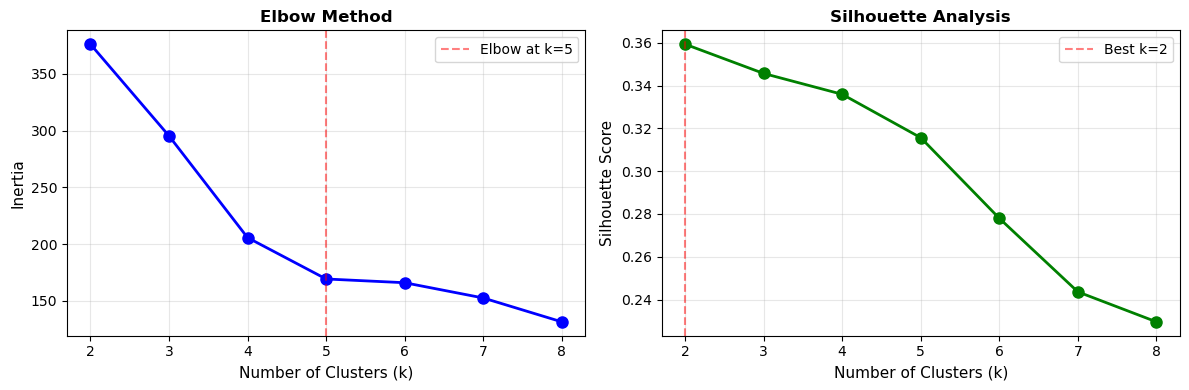

In [11]:
# TODO: Plot both metrics
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot inertia (elbow plot)
# X-axis: K_range, Y-axis: inertias
ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
ax1.set_xlabel('Number of Clusters (k)', fontsize=11)
ax1.set_ylabel('Inertia', fontsize=11)
ax1.set_title('Elbow Method', fontsize=12, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.axvline(x=5, color='r', linestyle='--', alpha=0.5, label='Elbow at k=5')
ax1.legend()

# Plot silhouette scores
# X-axis: K_range, Y-axis: silhouettes
ax2.plot(K_range, silhouettes, 'go-', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Clusters (k)', fontsize=11)
ax2.set_ylabel('Silhouette Score', fontsize=11)
ax2.set_title('Silhouette Analysis', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)

# Add a marker for the best k
best_k_idx = np.argmax(silhouettes)
best_k = K_range[best_k_idx]
ax2.axvline(x=best_k, color='r', linestyle='--', alpha=0.5, label=f'Best k={best_k}')
ax2.legend()

plt.tight_layout()
plt.show()

### Q: What k looks optimal?

### A:
k = 5 Loooks the most optimal because the clusters have the most tightly compact, and still has a similarities between them for the silhouette score. 

----

 ## PART 3: Cluster and Visualize

In [23]:
# TODO: Perform clustering with your chosen k

In [17]:
optimal_k = 5 # Replace with your choice
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
songs['cluster'] = kmeans.fit_predict(X_scaled)

print(f"✓ Created {optimal_k} clusters\n")
print(f"Cluster sizes:")
print(songs['cluster'].value_counts().sort_index())
print()

✓ Created 5 clusters

Cluster sizes:
cluster
0    10
1    28
2    10
3    32
4    20
Name: count, dtype: int64



In [16]:
# ==============================================================================
# CLUSTER CHARACTERISTICS
# ==============================================================================
print("=" * 80)
print("Average Feature Values for Each Cluster")
print("=" * 80)

# Group by the cluster label and calculate the mean for the feature columns
cluster_means = songs.groupby('cluster')[features].mean().round(2)
print(cluster_means)
print()

# ==============================================================================
# EXAMPLE CLUSTER INTERPRETATION
# ==============================================================================
print("=" * 80)
print("CLUSTER DESCRIPTIONS")
print("=" * 80)

for i in range(optimal_k):
    profile = cluster_means.loc[i]
    print(f"\nCluster {i}:")
    
    # Identify strongest and weakest features
    sorted_feats = profile.sort_values(ascending=False)
    print(f"   Highest features: {sorted_feats.head(2).to_dict()}")
    print(f"   Lowest features:  {sorted_feats.tail(2).to_dict()}")

    # Interpretation based on feature profiles
    if profile["energy"] > 0.7 and profile["danceability"] > 0.6:
        print("   → Interpreted as high-energy, dance-oriented music (EDM/party styles)")
    elif profile["acousticness"] > 0.7 and profile["energy"] < 0.3:
        print("   → Interpreted as calm, soft, acoustic or classical-leaning music")
    elif profile["speechiness"] > 0.15 and profile["danceability"] > 0.6:
        print("   → Interpreted as hip-hop/rap (high speech content + strong rhythm)")
    elif profile["energy"] > 0.6 and profile["acousticness"] < 0.3:
        print("   → Interpreted as guitar/rock/high-energy non-electronic music")
    else:
        print("   → Interpreted as moderate energy/acoustic singer-songwriter style")

print()

Average Feature Values for Each Cluster
         danceability  energy  acousticness  speechiness   tempo  loudness
cluster                                                                   
0                0.09    0.17          0.96         0.04   69.09    -20.00
1                0.43    0.54          0.62         0.05  105.37     -9.75
2                0.80    0.61          0.12         0.26   98.25     -2.92
3                0.62    0.83          0.14         0.03  124.39     -3.14
4                0.67    0.54          0.20         0.05   94.12     -6.72

CLUSTER DESCRIPTIONS

Cluster 0:
   Highest features: {'tempo': 69.09, 'acousticness': 0.96}
   Lowest features:  {'speechiness': 0.04, 'loudness': -20.0}
   → Interpreted as calm, soft, acoustic or classical-leaning music

Cluster 1:
   Highest features: {'tempo': 105.37, 'acousticness': 0.62}
   Lowest features:  {'speechiness': 0.05, 'loudness': -9.75}
   → Interpreted as moderate energy/acoustic singer-songwriter style

Cluste

In [18]:

print("="*80)
print("GENRE DISTRIBUTION PER CLUSTER:")
print("="*80)
for i in range(optimal_k):
    cluster_songs = songs[songs['cluster'] == i]
    genre_counts = cluster_songs['genre'].value_counts()
    print(f"\nCluster {i} ({len(cluster_songs)} songs):")
    for genre, count in genre_counts.items():
        pct = (count / len(cluster_songs)) * 100
        print(f"  {genre}: {count} ({pct:.1f}%)")

print()


GENRE DISTRIBUTION PER CLUSTER:

Cluster 0 (10 songs):
  Classical: 10 (100.0%)

Cluster 1 (28 songs):
  Jazz: 10 (35.7%)
  Country: 9 (32.1%)
  Indie: 8 (28.6%)
  R&B: 1 (3.6%)

Cluster 2 (10 songs):
  Hip-Hop: 10 (100.0%)

Cluster 3 (32 songs):
  Metal: 10 (31.2%)
  Electronic: 10 (31.2%)
  Pop: 6 (18.8%)
  Rock: 6 (18.8%)

Cluster 4 (20 songs):
  R&B: 9 (45.0%)
  Rock: 4 (20.0%)
  Pop: 4 (20.0%)
  Indie: 2 (10.0%)
  Country: 1 (5.0%)



## Analysis

### Q: Do your clusters match the actual genres? Why or why not?

### A:
I think 2 of them are perfect with the 10 hiphop and classical. Some are a little mixed but the categories are similar. Like the cluster 3 has like high energy music. Cluster 1 is like chill music with instruments. Cluster 4 is like radio music.

### Q: Are traditional genre labels useful, or should Spotify use clusters based on audio features instead?

### A:
I think the genre labels are useful because they tell more about the instruments and sound, really these specific audio features are not better than those in my opinion.

### Key Takeaway 🔑

K-means clustering reveals that music naturally groups
by audio characteristics, sometimes challenging traditional genre boundaries.
This is why recommendation systems work better than just matching genres!